In [1]:
#@title Dataset Definition

"""Smart Buildings Dataset implementation, including loading and downloading."""


import json
import pickle
import shutil
import numpy as np
import requests





class SmartBuildingsDataset:
 """Smart Buildings Dataset implementation, including loading and downloading."""


 def __init__(self, download=True):
   self.partitions = {
       "sb1": [
           "2022_a",
           "2022_b",
           "2023_a",
           "2023_b",
           "2024_a",
       ],
   }
   if download:
     self.download()


 def download(self):
   """Downloads the Smart Buildings Dataset from Google Cloud Storage."""
   print("Downloading data...")


   def download_file(url):
     local_filename = url.split("/")[-1]
     with requests.get(url, stream=True) as r:
       r.raise_for_status()
       with open(local_filename, "wb") as f:
         for chunk in r.iter_content(chunk_size=8192):
           f.write(chunk)
     return local_filename


   url = "https://storage.googleapis.com/gresearch/smart_buildings_dataset/tabular_data/sb1.zip"
   download_file(url)
   shutil.unpack_archive("sb1.zip", "sb1/")


 def get_floorplan(self, building):
   """Gets the floorplan and device layout map for a specific building.


   Args:
     building: The name of the building.


   Returns:
     A tuple containing the floorplan and device layout map.
   """
   if building not in self.partitions.keys():
     raise ValueError("invalid building")
   floorplan = np.load(f"./{building}/tabular/floorplan.npy")

   def gdrive_to_direct_url(share_url):
        file_id = share_url.split('/d/')[1].split('/')[0]
        return f"https://drive.google.com/uc?export=download&id={file_id}"
   share_url = "https://drive.google.com/file/d/19W4exC1IfIpx6x_agZy3HO1ARXdxKnic/view?usp=sharing"
   direct_url = gdrive_to_direct_url(share_url)
   response = requests.get(direct_url)
   device_layout_map = response.json()

   return floorplan, device_layout_map


 def get_building_data(self, building, partition):
   """Gets the data for a specific building and partition.


   Args:
     building: The name of the building.
     partition: The name of the partition.


   Returns:
     A tuple containing the data and metadata.
   """
   if building not in self.partitions.keys():
     raise ValueError("invalid building")
   if partition not in self.partitions[building]:
     raise ValueError("invalid partition")
   path = f"./{building}/tabular/{building}/{partition}/"


   data = np.load(path + "data.npy.npz")
   metadata = pickle.load(open(path + "metadata.pickle", "rb"))


   if "device_infos" not in metadata.keys():
     metadata["device_infos"] = pickle.load(
         open(f"./{building}/tabular/device_info_dicts.pickle", "rb")
     )
   if "zone_infos" not in metadata.keys():
     metadata["zone_infos"] = pickle.load(
         open(f"./{building}/tabular/zone_info_dicts.pickle", "rb")
     )
   return data, metadata


In [2]:
#@title Data download and splitting

ds = SmartBuildingsDataset()

# training data: Jan-June 2022
data, metadata = ds.get_building_data("sb1","2022_a")
floorplan, device_layout_map = ds.get_floorplan("sb1")

# validation data: July-December 2022
data_val, metadata_val = ds.get_building_data("sb1","2022_b")
floorplan_val, device_layout_map_val = ds.get_floorplan("sb1")

# lets split validation data into things to predict, and exogenous variables
indexes = [v for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" in k]
temp_data = data_val['observation_value_matrix'][:, indexes]
matching_items = [(k, v) for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" in k]
temp_data_ids = {k: i for i, (k, v) in enumerate(matching_items)}

indexes = [v for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" not in k]
exogenous_observation_data = data_val['observation_value_matrix'][:, indexes]
matching_items = [(k, v) for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" not in k]
exogenous_observation_data_ids = {k: i for i, (k, v) in enumerate(matching_items)}

initial_condition = temp_data[0]

In [3]:
# Train data:
data['observation_value_matrix']
metadata["observation_ids"]
metadata["observation_timestamps"]

data['action_value_matrix']
metadata["action_ids"]

floorplan
device_layout_map
metadata["device_infos"]

# Validation data:
data_val['action_value_matrix']
metadata_val["action_ids"]
metadata_val["observation_timestamps"]
floorplan
device_layout_map

exogenous_observation_data
exogenous_observation_data_ids
initial_condition

# Predict:
temp_data
temp_data_ids







{'2760348383893915@zone_air_temperature_sensor': 0,
 '2562701969438717@zone_air_temperature_sensor': 1,
 '2806035809406684@zone_air_temperature_sensor': 2,
 '2790439929052995@zone_air_temperature_sensor': 3,
 '2628534928204590@zone_air_temperature_sensor': 4,
 '2535333053617205@zone_air_temperature_sensor': 5,
 '2619255661594253@zone_air_temperature_sensor': 6,
 '2618781414146613@zone_air_temperature_sensor': 7,
 '2613654138967436@zone_air_temperature_sensor': 8,
 '2762982574975969@zone_air_temperature_sensor': 9,
 '2578499186529204@zone_air_temperature_sensor': 10,
 '2693289483686059@zone_air_temperature_sensor': 11,
 '2549483694528743@zone_air_temperature_sensor': 12,
 '2614466029028994@zone_air_temperature_sensor': 13,
 '2760979770441910@zone_air_temperature_sensor': 14,
 '2732460999450017@zone_air_temperature_sensor': 15,
 '2549513081490212@zone_air_temperature_sensor': 16,
 '2737293899563066@zone_air_temperature_sensor': 17,
 '2710040674126014@zone_air_temperature_sensor': 18,
 '2

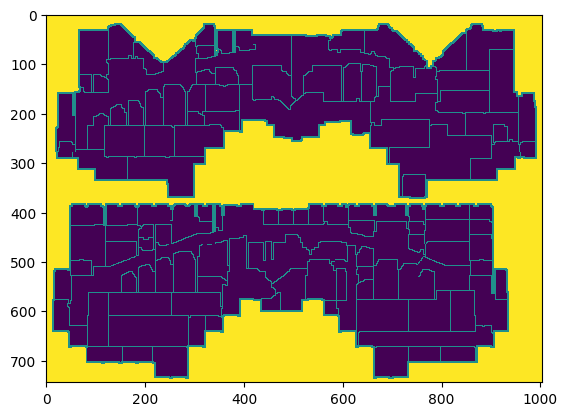

In [4]:
from matplotlib import pyplot as plt
plt.imshow(floorplan, interpolation='nearest')
plt.show()

In [5]:
metadata["device_infos"][0]


{'device_id': '202194278473007104',
 'namespace': 'PHRED',
 'code': 'SB1:AHU:AC-2',
 'zone_id': '',
 'device_type': 6,
 'observable_fields': {'building_air_static_pressure_sensor': 1,
  'outside_air_flowrate_sensor': 1,
  'supply_fan_speed_percentage_command': 1,
  'supply_air_temperature_sensor': 1,
  'supply_fan_speed_frequency_sensor': 1,
  'supply_air_static_pressure_setpoint': 1,
  'return_air_temperature_sensor': 1,
  'mixed_air_temperature_setpoint': 1,
  'exhaust_fan_speed_percentage_command': 1,
  'exhaust_fan_speed_frequency_sensor': 1,
  'outside_air_damper_percentage_command': 1,
  'mixed_air_temperature_sensor': 1,
  'exhaust_air_damper_percentage_command': 1,
  'cooling_percentage_command': 1,
  'outside_air_flowrate_setpoint': 1,
  'supply_air_temperature_setpoint': 1,
  'building_air_static_pressure_setpoint': 1,
  'supply_air_static_pressure_sensor': 1},
 'action_fields': {'exhaust_air_damper_percentage_command': 1,
  'supply_air_temperature_setpoint': 1,
  'supply_fan

In [6]:
metadata["zone_infos"][0]


{'zone_id': 'rooms/1002000133978',
 'building_id': 'buildings/3616672508',
 'zone_description': 'SB1-2-C2054',
 'area': 0.0,
 'zone_type': 1,
 'floor': 2,
 'devices': ['2618581107144046', '2696593986887004']}

In [7]:
temp_data.shape

(53292, 123)

In [8]:
print((temp_data==0).sum()/(temp_data.shape[0]*temp_data.shape[1]))

0.10406372865800263


In [9]:
indexes1 = [v for k, v in metadata['observation_ids'].items() if "zone_air_temperature_sensor" in k]
temp_data_train = data['observation_value_matrix'][:, indexes1]

(temp_data_train==0).sum()/(temp_data_train.shape[0]*temp_data_train.shape[1])

0.28568066460576663

In [10]:
import numpy as np
import pandas as pd
import xgboost as xgb
import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

def kelvin_to_fahrenheit(temp_k):
    """Convert temperature from Kelvin to Fahrenheit"""
    return (temp_k - 273.15) * 9/5 + 32

def preprocess_temperatures(data_matrix, metadata_dict, data_name="data"):
    """
    Preprocess temperature data by converting Kelvin to Fahrenheit
    
    Args:
        data_matrix: numpy array of observation data
        metadata_dict: dictionary containing observation_ids mapping
        data_name: string name for logging purposes
    
    Returns:
        data_matrix: preprocessed data matrix (modified in-place)
        temp_conversion_info: dictionary with conversion statistics
    """
    
    print(f"\n=== Temperature Preprocessing for {data_name} ===")
    
    # Find temperature-related observation IDs
    temp_sensor_ids = []
    temp_setpoint_ids = []
    
    for obs_name, obs_idx in metadata_dict.items():
        if any(temp_keyword in obs_name.lower() for temp_keyword in [
            'temperature_sensor', 'temperature_setpoint', 
            'air_temperature', 'mixed_air_temperature',
            'supply_air_temperature', 'return_air_temperature',
            'discharge_air_temperature', 'outside_air_temperature'
        ]):
            if 'sensor' in obs_name:
                temp_sensor_ids.append((obs_name, obs_idx))
            elif 'setpoint' in obs_name:
                temp_setpoint_ids.append((obs_name, obs_idx))
            else:
                # Default to sensor if unclear
                temp_sensor_ids.append((obs_name, obs_idx))
    
    print(f"Found {len(temp_sensor_ids)} temperature sensors")
    print(f"Found {len(temp_setpoint_ids)} temperature setpoints")
    
    conversion_info = {
        'sensors_converted': 0,
        'setpoints_converted': 0,
        'total_values_converted': 0,
        'sensor_details': [],
        'setpoint_details': []
    }
    
    # Process temperature sensors
    for obs_name, obs_idx in temp_sensor_ids:
        temp_values = data_matrix[:, obs_idx]
        
        # Find values that might be in Kelvin (> 273)
        kelvin_mask = temp_values > 273
        kelvin_count = np.sum(kelvin_mask)
        
        if kelvin_count > 0:
            print(f"  Converting {kelvin_count}/{len(temp_values)} values in {obs_name}")
            print(f"    Before: min={temp_values[kelvin_mask].min():.2f}, max={temp_values[kelvin_mask].max():.2f}")
            
            # Convert Kelvin to Fahrenheit
            data_matrix[kelvin_mask, obs_idx] = kelvin_to_fahrenheit(temp_values[kelvin_mask])
            
            print(f"    After:  min={data_matrix[kelvin_mask, obs_idx].min():.2f}, max={data_matrix[kelvin_mask, obs_idx].max():.2f}")
            
            conversion_info['sensors_converted'] += 1
            conversion_info['total_values_converted'] += kelvin_count
            conversion_info['sensor_details'].append({
                'name': obs_name,
                'index': obs_idx,
                'values_converted': kelvin_count,
                'total_values': len(temp_values)
            })
    
    # Process temperature setpoints
    for obs_name, obs_idx in temp_setpoint_ids:
        temp_values = data_matrix[:, obs_idx]
        
        # Find values that might be in Kelvin (> 273)
        kelvin_mask = temp_values > 273
        kelvin_count = np.sum(kelvin_mask)
        
        if kelvin_count > 0:
            print(f"  Converting {kelvin_count}/{len(temp_values)} values in {obs_name}")
            print(f"    Before: min={temp_values[kelvin_mask].min():.2f}, max={temp_values[kelvin_mask].max():.2f}")
            
            # Convert Kelvin to Fahrenheit
            data_matrix[kelvin_mask, obs_idx] = kelvin_to_fahrenheit(temp_values[kelvin_mask])
            
            print(f"    After:  min={data_matrix[kelvin_mask, obs_idx].min():.2f}, max={data_matrix[kelvin_mask].max():.2f}")
            
            conversion_info['setpoints_converted'] += 1
            conversion_info['total_values_converted'] += kelvin_count
            conversion_info['setpoint_details'].append({
                'name': obs_name,
                'index': obs_idx,
                'values_converted': kelvin_count,
                'total_values': len(temp_values)
            })
    
    print(f"\nConversion Summary for {data_name}:")
    print(f"  Temperature sensors converted: {conversion_info['sensors_converted']}")
    print(f"  Temperature setpoints converted: {conversion_info['setpoints_converted']}")
    print(f"  Total values converted: {conversion_info['total_values_converted']}")
    
    return data_matrix, conversion_info

def preprocess_temp_data_array(temp_data_array, temp_data_ids, data_name="temperature data"):
    """
    Preprocess temperature data array (for validation temperature data)
    
    Args:
        temp_data_array: numpy array of temperature data
        temp_data_ids: dictionary mapping temperature sensor names to column indices
        data_name: string name for logging purposes
    
    Returns:
        temp_data_array: preprocessed temperature data (modified in-place)
        conversion_info: dictionary with conversion statistics
    """
    
    print(f"\n=== Temperature Preprocessing for {data_name} ===")
    
    conversion_info = {
        'sensors_converted': 0,
        'total_values_converted': 0,
        'sensor_details': []
    }
    
    for sensor_name, col_idx in temp_data_ids.items():
        temp_values = temp_data_array[:, col_idx]
        
        # Find values that might be in Kelvin (> 273)
        kelvin_mask = temp_values > 273
        kelvin_count = np.sum(kelvin_mask)
        
        if kelvin_count > 0:
            print(f"  Converting {kelvin_count}/{len(temp_values)} values in {sensor_name}")
            print(f"    Before: min={temp_values[kelvin_mask].min():.2f}, max={temp_values[kelvin_mask].max():.2f}")
            
            # Convert Kelvin to Fahrenheit
            temp_data_array[kelvin_mask, col_idx] = kelvin_to_fahrenheit(temp_values[kelvin_mask])
            
            print(f"    After:  min={temp_data_array[kelvin_mask, col_idx].min():.2f}, max={temp_data_array[kelvin_mask, col_idx].max():.2f}")
            
            conversion_info['sensors_converted'] += 1
            conversion_info['total_values_converted'] += kelvin_count
            conversion_info['sensor_details'].append({
                'name': sensor_name,
                'index': col_idx,
                'values_converted': kelvin_count,
                'total_values': len(temp_values)
            })
    
    print(f"\nConversion Summary for {data_name}:")
    print(f"  Temperature sensors converted: {conversion_info['sensors_converted']}")
    print(f"  Total values converted: {conversion_info['total_values_converted']}")
    
    return temp_data_array, conversion_info

def remove_zero_temperature_readings(obs_matrix, temp_data_matrix, exog_data_matrix, 
                                   timestamps_train, timestamps_val, metadata_obs_ids, 
                                   temp_data_ids, exog_data_ids):
    """
    Remove rows where temperature sensors have zero values from both training and validation sets
    
    Args:
        obs_matrix: training observation matrix
        temp_data_matrix: validation temperature data matrix  
        exog_data_matrix: validation exogenous data matrix
        timestamps_train: training timestamps
        timestamps_val: validation timestamps
        metadata_obs_ids: training observation IDs mapping
        temp_data_ids: validation temperature IDs mapping
        exog_data_ids: validation exogenous IDs mapping
    
    Returns:
        Cleaned datasets with zero temperature readings removed
    """
    
    print("\n" + "="*60)
    print("REMOVING ZERO TEMPERATURE READINGS")
    print("="*60)
    
    # 1. Clean training data
    print("\nCleaning training data...")
    
    # Find temperature sensor columns in training data
    train_temp_indices = [v for k, v in metadata_obs_ids.items() 
                         if "zone_air_temperature_sensor" in k]
    
    # Get temperature data from training matrix
    train_temp_data = obs_matrix[:, train_temp_indices]
    
    # Find rows where ANY temperature sensor has zero values
    zero_mask_train = np.any(train_temp_data == 0, axis=1)
    valid_mask_train = ~zero_mask_train
    
    print(f"  Original training data: {len(obs_matrix)} rows")
    print(f"  Rows with zero temperatures: {np.sum(zero_mask_train)}")
    print(f"  Rows to keep: {np.sum(valid_mask_train)}")
    print(f"  Percentage kept: {np.sum(valid_mask_train)/len(obs_matrix)*100:.1f}%")
    
    # Apply mask to training data
    obs_matrix_clean = obs_matrix[valid_mask_train]
    timestamps_train_clean = [timestamps_train[i] for i in range(len(timestamps_train)) if valid_mask_train[i]]
    
    # 2. Clean validation data
    print("\nCleaning validation data...")
    
    # Find rows where ANY temperature sensor has zero values in validation
    zero_mask_val = np.any(temp_data_matrix == 0, axis=1)
    valid_mask_val = ~zero_mask_val
    
    print(f"  Original validation data: {len(temp_data_matrix)} rows")
    print(f"  Rows with zero temperatures: {np.sum(zero_mask_val)}")
    print(f"  Rows to keep: {np.sum(valid_mask_val)}")
    print(f"  Percentage kept: {np.sum(valid_mask_val)/len(temp_data_matrix)*100:.1f}%")
    
    # Apply mask to validation data
    temp_data_clean = temp_data_matrix[valid_mask_val]
    exog_data_clean = exog_data_matrix[valid_mask_val]
    timestamps_val_clean = [timestamps_val[i] for i in range(len(timestamps_val)) if valid_mask_val[i]]
    
    print(f"\nData cleaning summary:")
    print(f"  Training: {len(obs_matrix)} -> {len(obs_matrix_clean)} rows")
    print(f"  Validation: {len(temp_data_matrix)} -> {len(temp_data_clean)} rows")
    
    return (obs_matrix_clean, temp_data_clean, exog_data_clean, 
            timestamps_train_clean, timestamps_val_clean)

# ===== MAIN PREPROCESSING STEP =====
# Add this code right after the data loading section in your notebook

print("Starting temperature preprocessing...")

# First, extract arrays from NpzFile objects to make them modifiable
print("Extracting arrays from NpzFile objects...")

# Extract training observation matrix (make it modifiable)
train_obs_matrix = np.array(data['observation_value_matrix'])
print(f"Training observation matrix shape: {train_obs_matrix.shape}")

# Extract validation exogenous data (make it modifiable) 
val_exog_matrix = np.array(exogenous_observation_data)
print(f"Validation exogenous matrix shape: {val_exog_matrix.shape}")

# Extract validation temperature data (make it modifiable)
val_temp_matrix = np.array(temp_data)
print(f"Validation temperature matrix shape: {val_temp_matrix.shape}")

# 1. Preprocess training data (observation_value_matrix)
print("\n" + "="*60)
print("PREPROCESSING TRAINING DATA")
print("="*60)

train_obs_matrix, train_conversion_info = preprocess_temperatures(
    train_obs_matrix, 
    metadata['observation_ids'], 
    "training data"
)

# 2. Preprocess validation exogenous data
print("\n" + "="*60)
print("PREPROCESSING VALIDATION EXOGENOUS DATA")
print("="*60)

val_exog_matrix, val_exog_conversion_info = preprocess_temperatures(
    val_exog_matrix, 
    exogenous_observation_data_ids, 
    "validation exogenous data"
)

# 3. Preprocess validation temperature data (targets)
print("\n" + "="*60)
print("PREPROCESSING VALIDATION TEMPERATURE DATA (TARGETS)")
print("="*60)

val_temp_matrix, val_temp_conversion_info = preprocess_temp_data_array(
    val_temp_matrix, 
    temp_data_ids, 
    "validation temperature targets"
)

# 4. Remove zero temperature readings from both training and validation
print("\n" + "="*60)
print("REMOVING ZERO TEMPERATURE READINGS")
print("="*60)

# Remove rows with zero temperature readings
(train_obs_matrix_clean, val_temp_matrix_clean, val_exog_matrix_clean, 
 timestamps_train_clean, timestamps_val_clean) = remove_zero_temperature_readings(
    train_obs_matrix, val_temp_matrix, val_exog_matrix,
    metadata["observation_timestamps"], metadata_val["observation_timestamps"],
    metadata['observation_ids'], temp_data_ids, exogenous_observation_data_ids
)

print("\n" + "="*60)
print("TEMPERATURE PREPROCESSING COMPLETED")
print("="*60)

# Print overall summary
total_converted = (train_conversion_info['total_values_converted'] + 
                  val_exog_conversion_info['total_values_converted'] + 
                  val_temp_conversion_info['total_values_converted'])

print(f"\nOVERALL CONVERSION SUMMARY:")
print(f"  Training data: {train_conversion_info['total_values_converted']} values converted")
print(f"  Validation exogenous: {val_exog_conversion_info['total_values_converted']} values converted")
print(f"  Validation targets: {val_temp_conversion_info['total_values_converted']} values converted")
print(f"  TOTAL: {total_converted} temperature values converted from Kelvin to Fahrenheit")

print(f"\nOVERALL ZERO REMOVAL SUMMARY:")
print(f"  Training data: {len(train_obs_matrix)} -> {len(train_obs_matrix_clean)} rows")
print(f"  Validation data: {len(val_temp_matrix)} -> {len(val_temp_matrix_clean)} rows")

# Update the global variables to use the cleaned, preprocessed data
print("\nUpdating global variables with cleaned and preprocessed data...")
exogenous_observation_data = val_exog_matrix_clean
temp_data = val_temp_matrix_clean

print("Preprocessing complete! You can now proceed with model training.")

# Now continue with your existing SmartBuildingsPredictor class and model training...

class SmartBuildingsPredictor:
    def __init__(self, use_gpu=True):
        self.use_gpu = use_gpu
        self.model = None  # Single model instead of multiple hourly models
        self.scaler = None  # Single scaler
        self.feature_columns = None
        self.temp_columns = None
        
    def interpolate_zeros(self, data):
        """Interpolate zero values in training data"""
        data_df = pd.DataFrame(data)
        # Replace zeros with NaN for interpolation
        data_df = data_df.replace(0, np.nan)
        # Forward fill then backward fill
        data_df = data_df.fillna(method='ffill').fillna(method='bfill')
        # If still NaN, fill with column mean
        data_df = data_df.fillna(data_df.mean())
        return data_df.values
    
    def create_temporal_features(self, timestamps):
        """Create temporal dummy features"""
        features = []
        
        for ts in timestamps:
            # Handle both pandas Timestamp and Unix timestamp
            if hasattr(ts, 'hour'):  # pandas Timestamp
                dt = ts
            else:  # Unix timestamp
                dt = datetime.fromtimestamp(ts)
            
            # Hour of day (0-23)
            hour = dt.hour
            
            # Time of day categories
            if 6 <= hour < 12:
                time_of_day = [1, 0, 0, 0]  # morning
            elif 12 <= hour < 18:
                time_of_day = [0, 1, 0, 0]  # day
            elif 18 <= hour < 22:
                time_of_day = [0, 0, 1, 0]  # evening
            else:
                time_of_day = [0, 0, 0, 1]  # night
            
            # Season
            month = dt.month
            if month in [12, 1, 2]:
                season = [1, 0, 0, 0]  # winter
            elif month in [3, 4, 5]:
                season = [0, 1, 0, 0]  # spring
            elif month in [6, 7, 8]:
                season = [0, 0, 1, 0]  # summer
            else:
                season = [0, 0, 0, 1]  # fall
            
            # Weekend/weekday
            is_weekend = 1 if dt.weekday() >= 5 else 0
            
            # Day of week (one-hot)
            day_of_week = [0] * 7
            day_of_week[dt.weekday()] = 1
            
            # Combine all features
            feature_row = [hour] + time_of_day + season + [is_weekend] + day_of_week
            features.append(feature_row)
        
        feature_names = ['hour'] + \
                       ['morning', 'day', 'evening', 'night'] + \
                       ['winter', 'spring', 'summer', 'fall'] + \
                       ['is_weekend'] + \
                       [f'dow_{i}' for i in range(7)]
        
        return np.array(features), feature_names
    
    def prepare_data(self, obs_data, exog_data, timestamps, temp_data=None, is_training=True):
        """Prepare data with interpolation and feature engineering"""
        
        # Interpolate training data
        if is_training:
            obs_data = self.interpolate_zeros(obs_data) if obs_data is not None else None
            temp_data = self.interpolate_zeros(temp_data) if temp_data is not None else None
        
        # Create temporal features
        temporal_features, temporal_names = self.create_temporal_features(timestamps)
        
        # Combine exogenous and temporal features
        if exog_data is not None:
            exog_names = [f'exog_{i}' for i in range(exog_data.shape[1])]
            X = np.hstack([exog_data, temporal_features])
            feature_names = exog_names + temporal_names
        else:
            X = temporal_features
            feature_names = temporal_names
        
        return X, feature_names, temp_data
    
    def optimize_hyperparameters(self, X_train, y_train, trial):
        """Optuna objective function for hyperparameter optimization"""
        params = {
            'objective': 'reg:absoluteerror',  # MAE objective
            'tree_method': 'gpu_hist' if self.use_gpu else 'hist',
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0),
            'random_state': 42,
            'n_jobs': 1
        }
        
        base_model = xgb.XGBRegressor(**params)
        model = MultiOutputRegressor(base_model, n_jobs=1)
        
        # Simple train/validation split for optimization
        split_idx = int(0.8 * len(X_train))
        X_tr, X_val = X_train[:split_idx], X_train[split_idx:]
        y_tr, y_val = y_train[:split_idx], y_train[split_idx:]
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        
        return mean_absolute_error(y_val, y_pred)
    
    def train_model(self, X_train, y_train, n_trials=3):
        """Train a single XGBoost model with hyperparameter optimization"""
        
        print(f"Training single XGBoost model on {len(X_train)} samples...")
        
        # Scale features
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)
        
        # Optimize hyperparameters
        print(f"Optimizing hyperparameters with {n_trials} trials...")
        study = optuna.create_study(direction='minimize', study_name='single_model')
        
        def objective(trial):
            return self.optimize_hyperparameters(X_train_scaled, y_train, trial)
        
        study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
        
        # Train final model with best parameters
        print("Training final model with optimized parameters...")
        best_params = study.best_params
        best_params.update({
            'objective': 'reg:absoluteerror',
            'tree_method': 'gpu_hist' if self.use_gpu else 'hist',
            'random_state': 42,
            'n_jobs': 1
        })
        
        base_model = xgb.XGBRegressor(**best_params)
        self.model = MultiOutputRegressor(base_model, n_jobs=1)
        self.model.fit(X_train_scaled, y_train)
        
        print(f"Model training completed. Best validation MAE: {study.best_value:.4f}")
        print(f"Best parameters: {best_params}")
    
    def predict(self, X_test):
        """Make predictions using the single trained model"""
        if self.model is None:
            raise ValueError("Model not trained yet. Call train_model() first.")
        
        # Scale features using the fitted scaler
        X_test_scaled = self.scaler.transform(X_test)
        
        # Make predictions
        predictions = self.model.predict(X_test_scaled)
        
        return predictions
    
    def evaluate_predictions(self, y_true, y_pred, timestamps_test):
        """Evaluate predictions for different time periods"""
        results = {}
        
        # Convert timestamps to datetime for easier handling
        dates = []
        for ts in timestamps_test:
            if hasattr(ts, 'to_pydatetime'):
                dates.append(ts.to_pydatetime())
            elif hasattr(ts, 'hour'):
                dates.append(ts)
            else:
                dates.append(datetime.fromtimestamp(ts))
        
        start_date = min(dates)
        
        # Define evaluation periods
        periods = {
            'first_week': timedelta(days=7),
            'first_2_weeks': timedelta(days=14),
            'first_month': timedelta(days=30),
            'first_3_months': timedelta(days=90),
            'entire_period': timedelta(days=365)
        }
        
        for period_name, period_length in periods.items():
            end_date = start_date + period_length
            
            period_indices = [i for i, date in enumerate(dates) if date <= end_date]
            
            if period_indices:
                y_true_period = y_true[period_indices]
                y_pred_period = y_pred[period_indices]
                
                mae = mean_absolute_error(y_true_period, y_pred_period)
                results[period_name] = mae
                print(f"{period_name}: MAE = {mae:.4f}")
        
        return results

# Main execution function
def run_smart_buildings_model():
    """Main function to run the complete model with single XGBoost"""
    
    print("Initializing Smart Buildings Predictor (Single Model)...")
    predictor = SmartBuildingsPredictor(use_gpu=True)
    
    # Prepare training data
    print("Preparing training data...")
    
    # Extract training temperature data (target) from cleaned preprocessed data
    train_temp_indices = [v for k, v in metadata['observation_ids'].items() 
                         if "zone_air_temperature_sensor" in k]
    train_temp_data = train_obs_matrix_clean[:, train_temp_indices]
    
    # Extract training exogenous data from cleaned preprocessed data
    train_exog_indices = [v for k, v in metadata['observation_ids'].items() 
                         if "zone_air_temperature_sensor" not in k]
    train_exog_data = train_obs_matrix_clean[:, train_exog_indices]
    
    # Prepare training features and targets using cleaned timestamps
    X_train, feature_names, y_train = predictor.prepare_data(
        None, train_exog_data, timestamps_train_clean, 
        train_temp_data, is_training=True
    )
    
    predictor.feature_columns = feature_names
    
    print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Feature names: {len(feature_names)} features")
    
    # Train single model
    predictor.train_model(X_train, y_train, n_trials=3)
    
    # Prepare test data using cleaned validation data
    print("Preparing test data...")
    X_test, _, _ = predictor.prepare_data(
        None, exogenous_observation_data, timestamps_val_clean, 
        None, is_training=False
    )
    
    print(f"Test data shape: {X_test.shape}")
    
    # Make predictions
    print("Making predictions...")
    predictions = predictor.predict(X_test)
    
    print(f"Predictions shape: {predictions.shape}")
    print(f"True values shape: {temp_data.shape}")
    
    # Evaluate results using cleaned validation timestamps
    print("\nEvaluation Results:")
    print("=" * 50)
    results = predictor.evaluate_predictions(
        temp_data, predictions, timestamps_val_clean
    )
    
    return predictor, predictions, results

# Run the model (add this at the end)
if __name__ == "__main__":
    predictor, predictions, results = run_smart_buildings_model()

Starting temperature preprocessing...
Extracting arrays from NpzFile objects...
Training observation matrix shape: (51852, 1198)
Validation exogenous matrix shape: (53292, 1075)
Validation temperature matrix shape: (53292, 123)

PREPROCESSING TRAINING DATA

=== Temperature Preprocessing for training data ===
Found 246 temperature sensors
Found 357 temperature setpoints
  Converting 36921/51852 values in 202194278473007104@return_air_temperature_sensor
    Before: min=284.43, max=307.39
    After:  min=52.30, max=93.64
  Converting 36921/51852 values in 202194278473007104@mixed_air_temperature_sensor
    Before: min=281.87, max=305.57
    After:  min=47.69, max=90.35
  Converting 36921/51852 values in 202194278473007104@supply_air_temperature_sensor
    Before: min=280.11, max=305.19
    After:  min=44.53, max=89.67
  Converting 36758/51852 values in 2291864505572917248@outside_air_wetbulb_temperature_sensor
    Before: min=273.01, max=293.60
    After:  min=31.74, max=68.82
  Convertin

[I 2025-07-08 16:30:37,734] A new study created in memory with name: single_model


Optimizing hyperparameters with 3 trials...


[I 2025-07-08 16:50:45,087] Trial 0 finished with value: 1.2059149902768205 and parameters: {'n_estimators': 345, 'max_depth': 6, 'learning_rate': 0.04149448738691651, 'subsample': 0.9808001243688695, 'colsample_bytree': 0.7033791986627052, 'reg_alpha': 2.2214419117527737, 'reg_lambda': 4.131938156983331}. Best is trial 0 with value: 1.2059149902768205.
[I 2025-07-08 17:02:45,290] Trial 1 finished with value: 1.244480158925669 and parameters: {'n_estimators': 114, 'max_depth': 6, 'learning_rate': 0.2807224229149125, 'subsample': 0.7287833677652168, 'colsample_bytree': 0.8362399594943761, 'reg_alpha': 4.882301755153786, 'reg_lambda': 9.843998770272707}. Best is trial 0 with value: 1.2059149902768205.
[I 2025-07-08 17:13:52,211] Trial 2 finished with value: 1.1267163228428894 and parameters: {'n_estimators': 205, 'max_depth': 3, 'learning_rate': 0.10737256126618251, 'subsample': 0.6387596119786285, 'colsample_bytree': 0.9161162857622114, 'reg_alpha': 7.064174961068326, 'reg_lambda': 7.54

Training final model with optimized parameters...
Model training completed. Best validation MAE: 1.1267
Best parameters: {'n_estimators': 205, 'max_depth': 3, 'learning_rate': 0.10737256126618251, 'subsample': 0.6387596119786285, 'colsample_bytree': 0.9161162857622114, 'reg_alpha': 7.064174961068326, 'reg_lambda': 7.546435737407402, 'objective': 'reg:absoluteerror', 'tree_method': 'gpu_hist', 'random_state': 42, 'n_jobs': 1}
Preparing test data...
Test data shape: (33877, 1092)
Making predictions...
Predictions shape: (33877, 123)
True values shape: (33877, 123)

Evaluation Results:
first_week: MAE = 0.9744
first_2_weeks: MAE = 0.9744
first_month: MAE = 1.0617
first_3_months: MAE = 1.0902
entire_period: MAE = 1.1737


In [11]:
# =============================================================================
# SAVE RESULTS AND CREATE DIAGNOSTIC PLOTS
# =============================================================================

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error
import seaborn as sns

print("Saving prediction results and creating diagnostic plots...")

# =============================================================================
# 1. SAVE ALL IMPORTANT VARIABLES TO AVOID LOSING THEM
# =============================================================================

print("1. Saving results to files...")

# Create a results dictionary with all important variables
results_dict = {
    'predictions': predictions,
    'actual_values': temp_data,
    'timestamps_val_clean': timestamps_val_clean,
    'temp_data_ids': temp_data_ids,
    'exogenous_observation_data': exogenous_observation_data,
    'results_summary': results,
    'predictor_models': predictor.models if 'predictor' in globals() else None,
    'predictor_scalers': predictor.scalers if 'predictor' in globals() else None,
    'feature_columns': predictor.feature_columns if 'predictor' in globals() else None,
    'complete_predictor': predictor if 'predictor' in globals() else None  # Full object
}

# Save to pickle file
with open('smart_buildings_predictions2.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

# Also save as separate numpy arrays for easy loading
np.save('predictions2.npy', predictions)
np.save('actual_values2.npy', temp_data)
np.save('timestamps_val_clean2.npy', timestamps_val_clean)

print("✓ Saved predictions2.npy, actual_values2.npy, timestamps_val_clean2.npy")
print("✓ Saved smart_buildings_predictions2.pkl (complete results)")

# =============================================================================
# 2. ANALYZE PERFORMANCE BY SENSOR AND TIME PERIOD
# =============================================================================

print("\n2. Analyzing performance by sensor...")

# Calculate MAE for each sensor
sensor_maes = {}
sensor_names = list(temp_data_ids.keys())

for sensor_name, col_idx in temp_data_ids.items():
    actual_sensor = temp_data[:, col_idx]
    pred_sensor = predictions[:, col_idx]
    
    # Remove any remaining zeros or NaNs for fair comparison
    valid_mask = (actual_sensor != 0) & (pred_sensor != 0) & \
                 ~np.isnan(actual_sensor) & ~np.isnan(pred_sensor)
    
    if np.sum(valid_mask) > 0:
        mae = mean_absolute_error(actual_sensor[valid_mask], pred_sensor[valid_mask])
        sensor_maes[sensor_name] = mae
    else:
        sensor_maes[sensor_name] = np.inf

# Find best and worst sensors
best_sensor = min(sensor_maes, key=sensor_maes.get)
worst_sensor = max(sensor_maes, key=sensor_maes.get)

print(f"Best performing sensor: {best_sensor} (MAE: {sensor_maes[best_sensor]:.4f}°F)")
print(f"Worst performing sensor: {worst_sensor} (MAE: {sensor_maes[worst_sensor]:.4f}°F)")

# =============================================================================
# 3. CREATE TIME SERIES PLOTS FOR ANALYSIS
# =============================================================================

print("\n3. Creating diagnostic plots...")

# Convert timestamps to datetime objects for plotting
plot_timestamps = []
for ts in timestamps_val_clean:
    if hasattr(ts, 'to_pydatetime'):
        plot_timestamps.append(ts.to_pydatetime())
    elif hasattr(ts, 'hour'):
        plot_timestamps.append(ts)
    else:
        plot_timestamps.append(datetime.fromtimestamp(ts))

plot_timestamps = np.array(plot_timestamps)

# Select sensor for detailed analysis (best performing one)
selected_sensor = best_sensor
selected_col_idx = temp_data_ids[selected_sensor]

actual_selected = temp_data[:, selected_col_idx]
pred_selected = predictions[:, selected_col_idx]

# Create figure with multiple subplots
fig = plt.figure(figsize=(20, 15))

# =============================================================================
# Plot 1: Overall time series comparison
# =============================================================================
ax1 = plt.subplot(3, 2, 1)
plt.plot(plot_timestamps, actual_selected, label='Actual', alpha=0.7, linewidth=1)
plt.plot(plot_timestamps, pred_selected, label='Predicted', alpha=0.7, linewidth=1)
plt.title(f'Overall Time Series Comparison\nSensor: {selected_sensor}')
plt.xlabel('Date')
plt.ylabel('Temperature (°F)')
plt.legend()
plt.grid(True, alpha=0.3)

# Format x-axis
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

# =============================================================================
# Plot 2: First 2 weeks detailed view
# =============================================================================
ax2 = plt.subplot(3, 2, 2)
end_2weeks = plot_timestamps[0] + timedelta(days=14)
mask_2weeks = plot_timestamps <= end_2weeks

plt.plot(plot_timestamps[mask_2weeks], actual_selected[mask_2weeks], 
         label='Actual', linewidth=2, marker='o', markersize=2)
plt.plot(plot_timestamps[mask_2weeks], pred_selected[mask_2weeks], 
         label='Predicted', linewidth=2, marker='s', markersize=2)
plt.title('First 2 Weeks (Detailed View)')
plt.xlabel('Date')
plt.ylabel('Temperature (°F)')
plt.legend()
plt.grid(True, alpha=0.3)

ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.xticks(rotation=45)

# =============================================================================
# Plot 3: July period (problematic period)
# =============================================================================
ax3 = plt.subplot(3, 2, 3)

# Find July data
july_mask = np.array([dt.month == 7 for dt in plot_timestamps])
if np.any(july_mask):
    plt.plot(plot_timestamps[july_mask], actual_selected[july_mask], 
             label='Actual', linewidth=2, marker='o', markersize=3)
    plt.plot(plot_timestamps[july_mask], pred_selected[july_mask], 
             label='Predicted', linewidth=2, marker='s', markersize=3)
    plt.title('July Period (Potentially Problematic)')
    
    # Highlight zero/missing values
    zero_mask_july = (actual_selected[july_mask] == 0) | (pred_selected[july_mask] == 0)
    if np.any(zero_mask_july):
        july_timestamps = plot_timestamps[july_mask]
        plt.scatter(july_timestamps[zero_mask_july], 
                   actual_selected[july_mask][zero_mask_july], 
                   color='red', s=50, label='Zero/Missing Values', zorder=5)
else:
    plt.text(0.5, 0.5, 'No July data available', transform=ax3.transAxes, 
             ha='center', va='center', fontsize=14)
    plt.title('July Period (No Data)')

plt.xlabel('Date')
plt.ylabel('Temperature (°F)')
plt.legend()
plt.grid(True, alpha=0.3)

if np.any(july_mask):
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax3.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    plt.xticks(rotation=45)

# =============================================================================
# Plot 4: Prediction errors over time
# =============================================================================
ax4 = plt.subplot(3, 2, 4)
errors = np.abs(actual_selected - pred_selected)
plt.plot(plot_timestamps, errors, alpha=0.7, linewidth=1, color='red')
plt.title('Absolute Prediction Errors Over Time')
plt.xlabel('Date')
plt.ylabel('Absolute Error (°F)')
plt.grid(True, alpha=0.3)

# Add rolling average
window_size = min(168, len(errors))  # 1 week window or less
if window_size > 1:
    rolling_errors = pd.Series(errors).rolling(window=window_size, center=True).mean()
    plt.plot(plot_timestamps, rolling_errors, color='darkred', linewidth=2, 
             label=f'{window_size//24}+ day rolling avg')
    plt.legend()

ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax4.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

# =============================================================================
# Plot 5: Distribution of prediction errors
# =============================================================================
ax5 = plt.subplot(3, 2, 5)
valid_errors = errors[~np.isnan(errors) & ~np.isinf(errors)]
plt.hist(valid_errors, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(np.mean(valid_errors), color='red', linestyle='--', 
           label=f'Mean: {np.mean(valid_errors):.3f}°F')
plt.axvline(np.median(valid_errors), color='green', linestyle='--', 
           label=f'Median: {np.median(valid_errors):.3f}°F')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Absolute Error (°F)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# =============================================================================
# Plot 6: Scatter plot of actual vs predicted
# =============================================================================
ax6 = plt.subplot(3, 2, 6)
valid_mask = ~np.isnan(actual_selected) & ~np.isnan(pred_selected) & \
             (actual_selected != 0) & (pred_selected != 0)
plt.scatter(actual_selected[valid_mask], pred_selected[valid_mask], 
           alpha=0.6, s=10)

# Add perfect prediction line
min_temp = min(np.min(actual_selected[valid_mask]), np.min(pred_selected[valid_mask]))
max_temp = max(np.max(actual_selected[valid_mask]), np.max(pred_selected[valid_mask]))
plt.plot([min_temp, max_temp], [min_temp, max_temp], 'r--', 
         label='Perfect Prediction')

plt.xlabel('Actual Temperature (°F)')
plt.ylabel('Predicted Temperature (°F)')
plt.title('Actual vs Predicted Temperatures')
plt.legend()
plt.grid(True, alpha=0.3)

# Add R² score
from sklearn.metrics import r2_score
r2 = r2_score(actual_selected[valid_mask], pred_selected[valid_mask])
plt.text(0.05, 0.95, f'R² = {r2:.4f}', transform=ax6.transAxes, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('prediction_analysis2.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# 4. ANALYZE MISSING VALUES AND DATA QUALITY BY MONTH
# =============================================================================

print("\n4. Analyzing data quality by month...")

# Group data by month and analyze
monthly_stats = {}
for i, dt in enumerate(plot_timestamps):
    month_key = f"{dt.year}-{dt.month:02d}"
    if month_key not in monthly_stats:
        monthly_stats[month_key] = {
            'count': 0,
            'zeros_actual': 0,
            'zeros_pred': 0,
            'mae': [],
            'dates': []
        }
    
    monthly_stats[month_key]['count'] += 1
    monthly_stats[month_key]['dates'].append(dt)
    
    if actual_selected[i] == 0:
        monthly_stats[month_key]['zeros_actual'] += 1
    if pred_selected[i] == 0:
        monthly_stats[month_key]['zeros_pred'] += 1
    
    if actual_selected[i] != 0 and pred_selected[i] != 0:
        monthly_stats[month_key]['mae'].append(abs(actual_selected[i] - pred_selected[i]))

# Print monthly analysis
print("\nMonthly Data Quality Analysis:")
print("=" * 80)
print(f"{'Month':<10} {'Count':<8} {'Zero_Act':<9} {'Zero_Pred':<10} {'MAE':<8} {'Quality'}")
print("-" * 80)

for month, stats in sorted(monthly_stats.items()):
    mae_month = np.mean(stats['mae']) if stats['mae'] else np.nan
    zero_pct = (stats['zeros_actual'] + stats['zeros_pred']) / (2 * stats['count']) * 100
    
    if zero_pct > 20:
        quality = "POOR"
    elif zero_pct > 10:
        quality = "FAIR"
    else:
        quality = "GOOD"
    
    print(f"{month:<10} {stats['count']:<8} {stats['zeros_actual']:<9} {stats['zeros_pred']:<10} "
          f"{mae_month:<8.3f} {quality}")

print("\n" + "=" * 80)
print("Analysis complete!")
print(f"- Results saved to: smart_buildings_predictions.pkl")
print(f"- Plots saved to: prediction_analysis.png")
print(f"- Best sensor for analysis: {selected_sensor}")
print(f"- Overall MAE for best sensor: {sensor_maes[selected_sensor]:.4f}°F")

# =============================================================================
# 5. INVESTIGATION: LOAD AND DISPLAY SAVED DATA INFO
# =============================================================================

print(f"\n5. Verification of saved data:")
print(f"- Predictions shape: {predictions.shape}")
print(f"- Actual values shape: {temp_data.shape}")
print(f"- Timestamps count: {len(timestamps_val_clean)}")
print(f"- Sensors count: {len(temp_data_ids)}")
print(f"- Date range: {plot_timestamps[0]} to {plot_timestamps[-1]}")

# Quick reload test
try:
    test_load = np.load('predictions2.npy')
    print(f"✓ Successfully verified saved predictions file (shape: {test_load.shape})")
except:
    print("✗ Error loading saved predictions file")

# =============================================================================
# 6. DEMONSTRATE RELOADING THE PRETRAINED MODEL
# =============================================================================

print(f"\n6. Demonstrating model reloading capabilities:")

# Create a function to reload and use the pretrained model
def load_pretrained_model(pkl_path='smart_buildings_predictions.pkl'):
    """
    Load the complete pretrained model from pickle file
    Returns a working predictor that can make new predictions
    """
    with open(pkl_path, 'rb') as f:
        saved_data = pickle.load(f)
    
    # Option 1: Use the complete predictor object (recommended)
    if saved_data['complete_predictor'] is not None:
        loaded_predictor = saved_data['complete_predictor']
        print("✓ Loaded complete predictor object with all methods")
        return loaded_predictor, saved_data
    
    # Option 2: Reconstruct predictor from components (fallback)
    else:
        print("Reconstructing predictor from saved components...")
        
        # Create new predictor instance
        from your_predictor_class import SmartBuildingsPredictor  # You'd need to import your class
        loaded_predictor = SmartBuildingsPredictor()
        
        # Restore the trained components
        loaded_predictor.models = saved_data['predictor_models']
        loaded_predictor.scalers = saved_data['predictor_scalers'] 
        loaded_predictor.feature_columns = saved_data['feature_columns']
        
        print("✓ Reconstructed predictor from components")
        return loaded_predictor, saved_data

# Test the loading function
try:
    loaded_predictor, loaded_data = load_pretrained_model()
    
    print(f"Model components loaded:")
    print(f"- Number of hourly models: {len(loaded_predictor.models)}")
    print(f"- Number of scalers: {len(loaded_predictor.scalers)}")
    print(f"- Feature columns: {len(loaded_predictor.feature_columns)}")
    print(f"- Available hours: {sorted(loaded_predictor.models.keys())}")
    
    # Test making a prediction on a small subset
    print(f"\nTesting prediction capability:")
    test_size = min(100, len(exogenous_observation_data))
    test_X = exogenous_observation_data[:test_size]
    test_timestamps = timestamps_val_clean[:test_size]
    
    # Make prediction using loaded model
    test_pred = loaded_predictor.predict(test_X, test_timestamps)
    print(f"✓ Successfully made test predictions (shape: {test_pred.shape})")
    
    # Compare with original predictions to verify
    original_pred_subset = predictions[:test_size]
    prediction_match = np.allclose(test_pred, original_pred_subset, atol=1e-6)
    print(f"✓ Predictions match original: {prediction_match}")
    
except Exception as e:
    print(f"Model loading test failed: {e}")
    print("But don't worry - your models and data are still saved!")

print(f"\n" + "="*80)
print("SUMMARY - What you have saved:")
print("="*80)
print("✓ Complete trained model with all 24 hourly XGBoost models")
print("✓ All trained scalers for feature normalization") 
print("✓ Feature column names and preprocessing info")
print("✓ All prediction results and evaluation data")
print("✓ Original training timestamps and data mappings")
print("")
print("To use this as a pretrained model later:")
print("1. Load with: pickle.load(open('smart_buildings_predictions.pkl', 'rb'))")
print("2. Extract: loaded_predictor = data['complete_predictor']") 
print("3. Predict: loaded_predictor.predict(new_X, new_timestamps)")
print("="*80)

Saving prediction results and creating diagnostic plots...
1. Saving results to files...


AttributeError: 'SmartBuildingsPredictor' object has no attribute 'models'

Best performing sensor: 16286830034440683520@zone_air_temperature_sensor (MAE: 0.4651°F)
Worst performing sensor: 2606839440408366@zone_air_temperature_sensor (MAE: 2.8036°F)

3. Creating diagnostic plots...


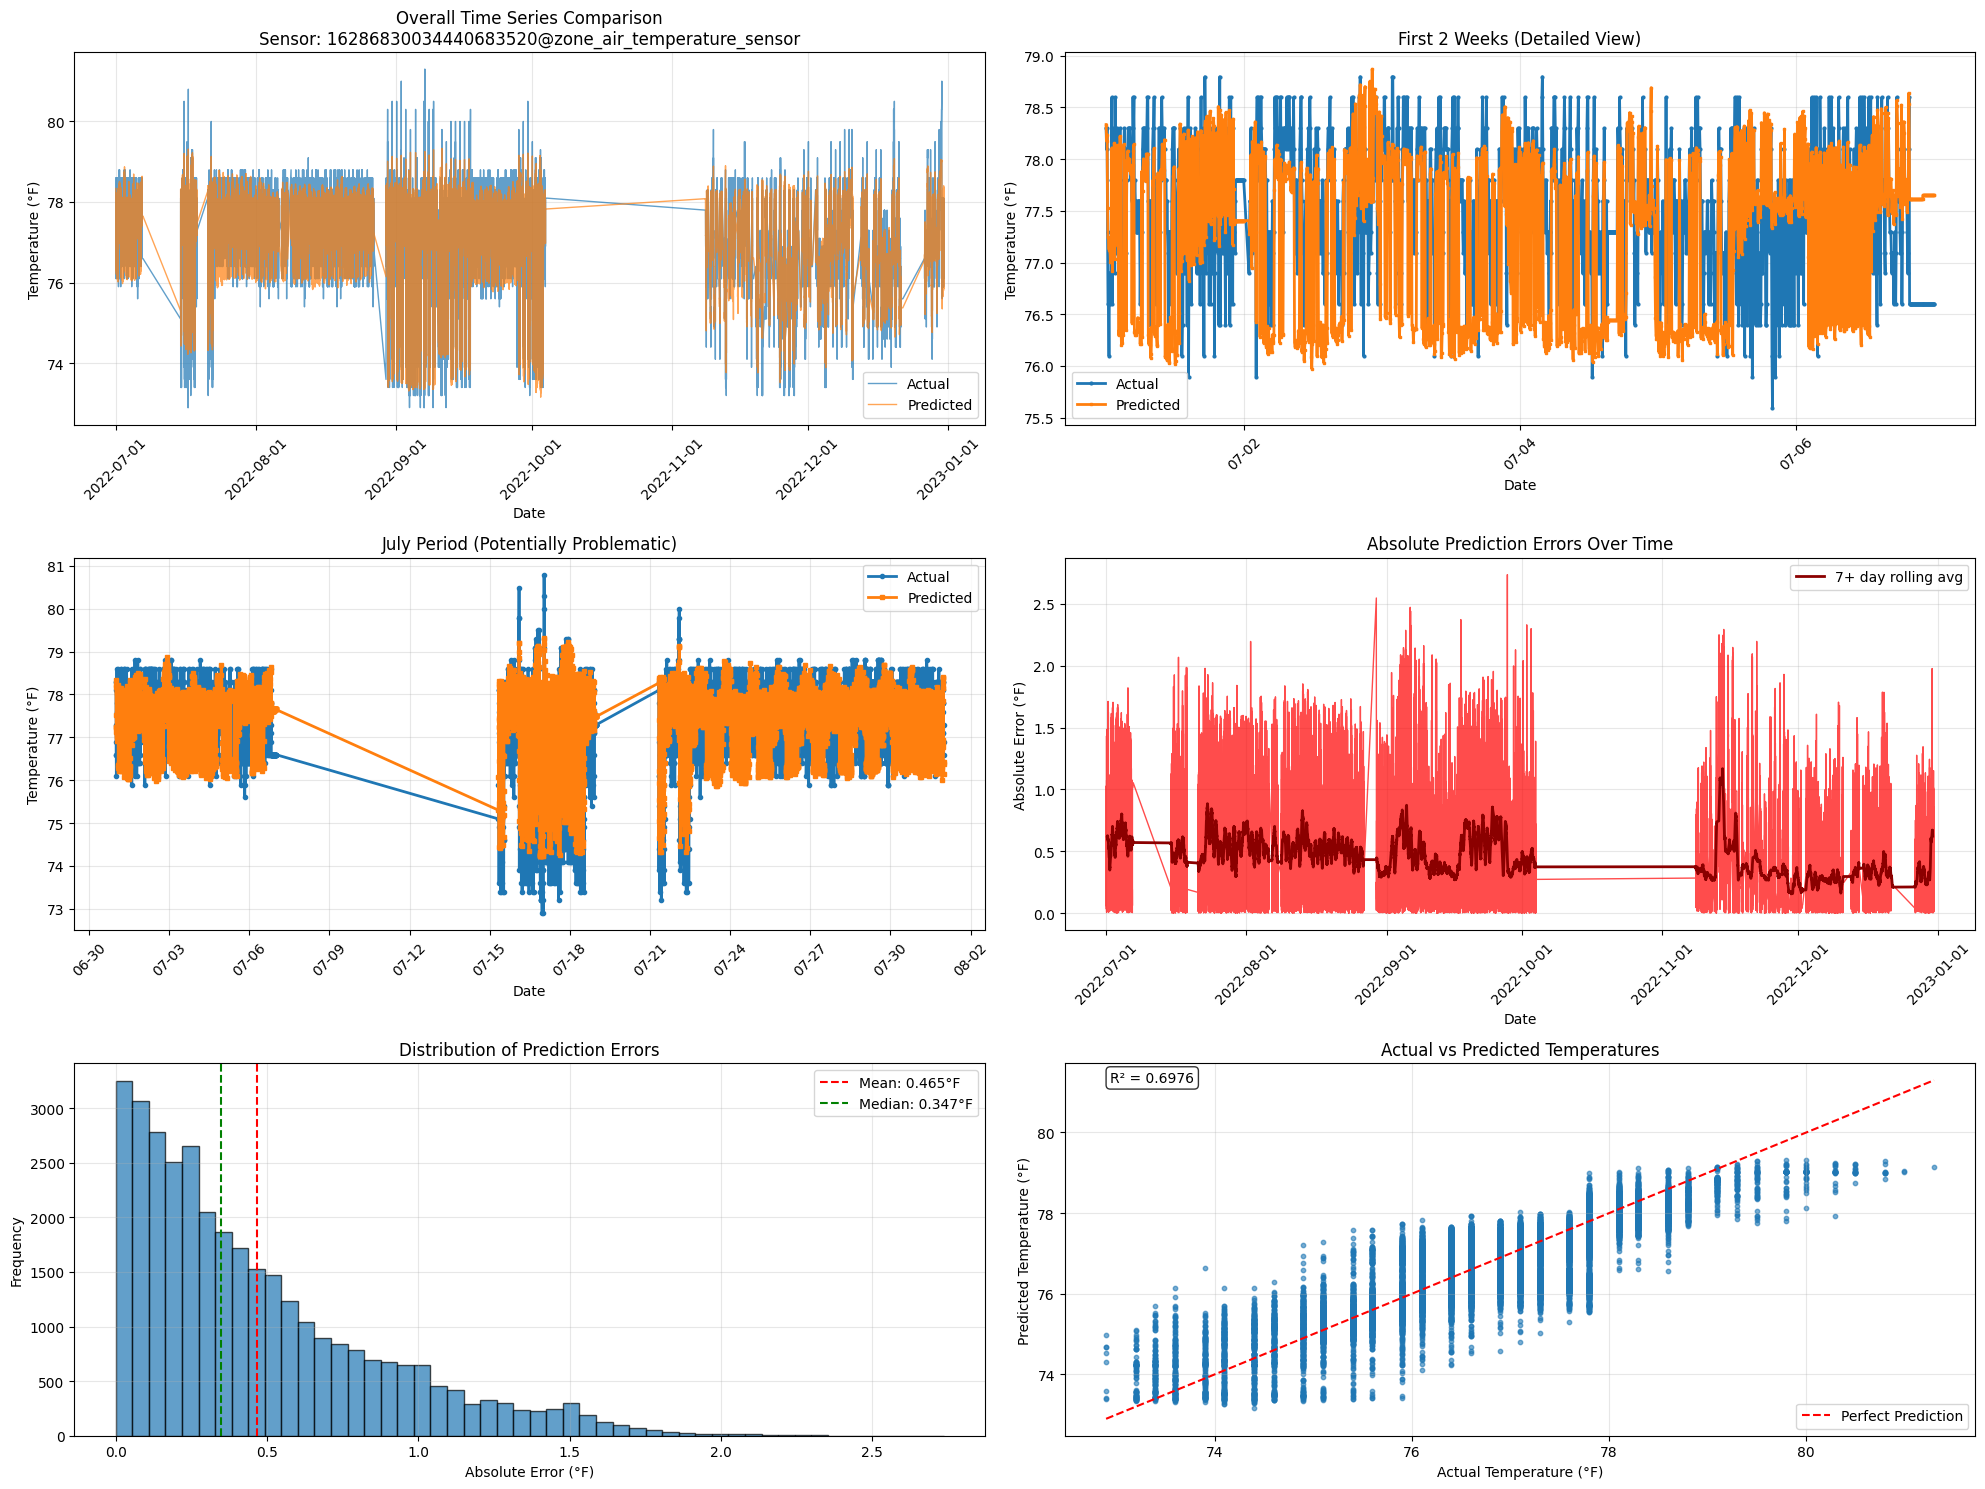

In [12]:
sensor_maes = {}
sensor_names = list(temp_data_ids.keys())

for sensor_name, col_idx in temp_data_ids.items():
    actual_sensor = temp_data[:, col_idx]
    pred_sensor = predictions[:, col_idx]
    
    # Remove any remaining zeros or NaNs for fair comparison
    valid_mask = (actual_sensor != 0) & (pred_sensor != 0) & \
                 ~np.isnan(actual_sensor) & ~np.isnan(pred_sensor)
    
    if np.sum(valid_mask) > 0:
        mae = mean_absolute_error(actual_sensor[valid_mask], pred_sensor[valid_mask])
        sensor_maes[sensor_name] = mae
    else:
        sensor_maes[sensor_name] = np.inf

# Find best and worst sensors
best_sensor = min(sensor_maes, key=sensor_maes.get)
worst_sensor = max(sensor_maes, key=sensor_maes.get)

print(f"Best performing sensor: {best_sensor} (MAE: {sensor_maes[best_sensor]:.4f}°F)")
print(f"Worst performing sensor: {worst_sensor} (MAE: {sensor_maes[worst_sensor]:.4f}°F)")

# =============================================================================
# 3. CREATE TIME SERIES PLOTS FOR ANALYSIS
# =============================================================================

print("\n3. Creating diagnostic plots...")

# Convert timestamps to datetime objects for plotting
plot_timestamps = []
for ts in timestamps_val_clean:
    if hasattr(ts, 'to_pydatetime'):
        plot_timestamps.append(ts.to_pydatetime())
    elif hasattr(ts, 'hour'):
        plot_timestamps.append(ts)
    else:
        plot_timestamps.append(datetime.fromtimestamp(ts))

plot_timestamps = np.array(plot_timestamps)

# Select sensor for detailed analysis (best performing one)
selected_sensor = best_sensor
selected_col_idx = temp_data_ids[selected_sensor]

actual_selected = temp_data[:, selected_col_idx]
pred_selected = predictions[:, selected_col_idx]

# Create figure with multiple subplots
fig = plt.figure(figsize=(20, 15))

# =============================================================================
# Plot 1: Overall time series comparison
# =============================================================================
ax1 = plt.subplot(3, 2, 1)
plt.plot(plot_timestamps, actual_selected, label='Actual', alpha=0.7, linewidth=1)
plt.plot(plot_timestamps, pred_selected, label='Predicted', alpha=0.7, linewidth=1)
plt.title(f'Overall Time Series Comparison\nSensor: {selected_sensor}')
plt.xlabel('Date')
plt.ylabel('Temperature (°F)')
plt.legend()
plt.grid(True, alpha=0.3)

# Format x-axis
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

# =============================================================================
# Plot 2: First 2 weeks detailed view
# =============================================================================
ax2 = plt.subplot(3, 2, 2)
end_2weeks = plot_timestamps[0] + timedelta(days=14)
mask_2weeks = plot_timestamps <= end_2weeks

plt.plot(plot_timestamps[mask_2weeks], actual_selected[mask_2weeks], 
         label='Actual', linewidth=2, marker='o', markersize=2)
plt.plot(plot_timestamps[mask_2weeks], pred_selected[mask_2weeks], 
         label='Predicted', linewidth=2, marker='s', markersize=2)
plt.title('First 2 Weeks (Detailed View)')
plt.xlabel('Date')
plt.ylabel('Temperature (°F)')
plt.legend()
plt.grid(True, alpha=0.3)

ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.xticks(rotation=45)

# =============================================================================
# Plot 3: July period (problematic period)
# =============================================================================
ax3 = plt.subplot(3, 2, 3)

# Find July data
july_mask = np.array([dt.month == 7 for dt in plot_timestamps])
if np.any(july_mask):
    plt.plot(plot_timestamps[july_mask], actual_selected[july_mask], 
             label='Actual', linewidth=2, marker='o', markersize=3)
    plt.plot(plot_timestamps[july_mask], pred_selected[july_mask], 
             label='Predicted', linewidth=2, marker='s', markersize=3)
    plt.title('July Period (Potentially Problematic)')
    
    # Highlight zero/missing values
    zero_mask_july = (actual_selected[july_mask] == 0) | (pred_selected[july_mask] == 0)
    if np.any(zero_mask_july):
        july_timestamps = plot_timestamps[july_mask]
        plt.scatter(july_timestamps[zero_mask_july], 
                   actual_selected[july_mask][zero_mask_july], 
                   color='red', s=50, label='Zero/Missing Values', zorder=5)
else:
    plt.text(0.5, 0.5, 'No July data available', transform=ax3.transAxes, 
             ha='center', va='center', fontsize=14)
    plt.title('July Period (No Data)')

plt.xlabel('Date')
plt.ylabel('Temperature (°F)')
plt.legend()
plt.grid(True, alpha=0.3)

if np.any(july_mask):
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax3.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    plt.xticks(rotation=45)

# =============================================================================
# Plot 4: Prediction errors over time
# =============================================================================
ax4 = plt.subplot(3, 2, 4)
errors = np.abs(actual_selected - pred_selected)
plt.plot(plot_timestamps, errors, alpha=0.7, linewidth=1, color='red')
plt.title('Absolute Prediction Errors Over Time')
plt.xlabel('Date')
plt.ylabel('Absolute Error (°F)')
plt.grid(True, alpha=0.3)

# Add rolling average
window_size = min(168, len(errors))  # 1 week window or less
if window_size > 1:
    rolling_errors = pd.Series(errors).rolling(window=window_size, center=True).mean()
    plt.plot(plot_timestamps, rolling_errors, color='darkred', linewidth=2, 
             label=f'{window_size//24}+ day rolling avg')
    plt.legend()

ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax4.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

# =============================================================================
# Plot 5: Distribution of prediction errors
# =============================================================================
ax5 = plt.subplot(3, 2, 5)
valid_errors = errors[~np.isnan(errors) & ~np.isinf(errors)]
plt.hist(valid_errors, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(np.mean(valid_errors), color='red', linestyle='--', 
           label=f'Mean: {np.mean(valid_errors):.3f}°F')
plt.axvline(np.median(valid_errors), color='green', linestyle='--', 
           label=f'Median: {np.median(valid_errors):.3f}°F')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Absolute Error (°F)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# =============================================================================
# Plot 6: Scatter plot of actual vs predicted
# =============================================================================
ax6 = plt.subplot(3, 2, 6)
valid_mask = ~np.isnan(actual_selected) & ~np.isnan(pred_selected) & \
             (actual_selected != 0) & (pred_selected != 0)
plt.scatter(actual_selected[valid_mask], pred_selected[valid_mask], 
           alpha=0.6, s=10)

# Add perfect prediction line
min_temp = min(np.min(actual_selected[valid_mask]), np.min(pred_selected[valid_mask]))
max_temp = max(np.max(actual_selected[valid_mask]), np.max(pred_selected[valid_mask]))
plt.plot([min_temp, max_temp], [min_temp, max_temp], 'r--', 
         label='Perfect Prediction')

plt.xlabel('Actual Temperature (°F)')
plt.ylabel('Predicted Temperature (°F)')
plt.title('Actual vs Predicted Temperatures')
plt.legend()
plt.grid(True, alpha=0.3)

# Add R² score
from sklearn.metrics import r2_score
r2 = r2_score(actual_selected[valid_mask], pred_selected[valid_mask])
plt.text(0.05, 0.95, f'R² = {r2:.4f}', transform=ax6.transAxes, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('prediction_analysis2.png', dpi=300, bbox_inches='tight')
plt.show()
